In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import time
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
class Dataloader(object):
    def __init__(self, X, y, batch_size, shuffle=True, seed=None):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.index = np.arange(X.shape[0])

    def __iter__(self):
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.index)
        self.n = 0
        return self

    def __next__(self):
        if self.n >= len(self.index):
            raise StopIteration
        index = self.index[self.n:self.n + self.batch_size]
        batch_X = self.X[index]
        batch_y = self.y[index]
        self.n += self.batch_size

        return batch_X, batch_y

    def __len__(self):
        return (len(self.index) + self.batch_size - 1) // self.batch_size

In [4]:
dir_path=''
train_file='train_data.npy'
train_label_file='train_label.npy'
test_file='test_data.npy'
test_label_file='test_label.npy'
train_data=np.load(dir_path+train_file)
train_label=np.load(dir_path+train_label_file)


test_data=np.load(dir_path+test_file)
test_label=np.load(dir_path+test_label_file)

In [5]:
train_data

array([[ -6.40101763,   2.72903876,   1.50171052, ...,   0.22933369,
         -0.1535829 ,   0.54404128],
       [  0.82978338,  -0.94994322,   6.0037526 , ...,   0.04319449,
         -0.0157158 ,  -0.28907615],
       [  7.73019978, -11.52210233,  -2.75362051, ...,   0.01458726,
         -0.35582987,   0.18428758],
       ...,
       [  0.70734659, -11.34252124,  -0.39391488, ...,  -0.49020993,
         -0.21487252,  -0.03641533],
       [ 11.36790901,  -3.37597765,   5.56619766, ...,  -0.63245635,
         -0.07775427,   0.56149881],
       [  4.19279645,  -1.18418848,  -4.44596297, ...,  -0.04935812,
          0.16881497,   0.07433337]])

In [6]:
train_label

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [8]:
test_data

array([[-3.47967057e+00,  9.06426369e-01,  1.25195572e+00, ...,
         8.61874214e-01,  6.31729322e-01,  2.60908392e-01],
       [ 9.94315784e+00, -9.58055259e+00,  5.06857801e+00, ...,
         1.63248427e-01, -3.18574521e-01, -2.67055346e-01],
       [ 4.70429957e+00, -8.83720616e+00,  4.10928532e+00, ...,
         5.57491883e-02,  2.65140024e-01,  1.67865616e-01],
       ...,
       [-1.52911933e+01,  2.50308666e+00, -2.27169405e-01, ...,
        -2.68454413e-01, -6.99688324e-02, -6.08919845e-01],
       [-5.85707877e+00,  2.04437491e+00,  3.65488937e+00, ...,
         7.85415991e-01,  6.86344933e-03,  2.01131653e-02],
       [-1.76542944e+00, -1.89117258e+00, -2.14885246e+00, ...,
        -4.11516440e-01,  1.87276097e-02,  2.38587672e-01]])

In [9]:
test_label

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [30]:
#Check data shapes and structure
print(f"Train data: {train_data.shape}")
print(f"Train label: {train_label.shape}")
print(f"Test data: {test_data.shape}")
print(f"Test label: {test_label.shape}")

Train data: (50000, 128)
Train label: (50000, 1)
Test data: (10000, 128)
Test label: (10000, 1)


In [18]:
# Check data types
print("=== Data Types ===")
print(f"Training data type: {train_data.dtype}")
print(f"Training labels type: {train_label.dtype}\n")

=== Data Types ===
Training data type: float64
Training labels type: uint8



In [11]:
print(f"Train data: {np.isnan(train_data).sum()} missing values")
print(f"Test data: {np.isnan(test_data).sum()} missing values")

Train data: 0 missing values
Test data: 0 missing values


In [12]:
#  Check for duplicates
train_df = pd.DataFrame(train_data)
print(f"\nDuplicate rows in training data: {train_df.duplicated().sum()}")


Duplicate rows in training data: 0


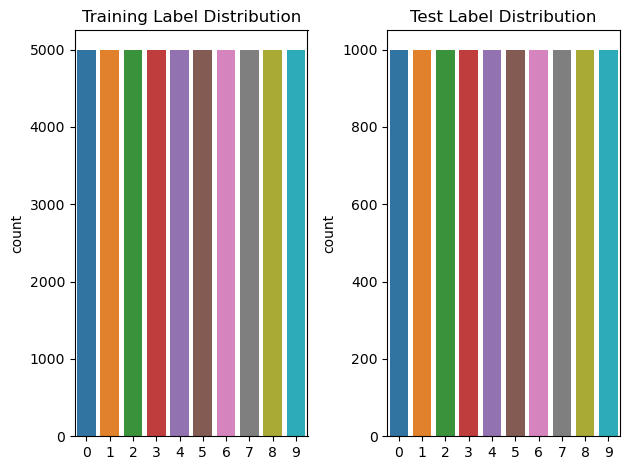

In [13]:
#Label Distribution Analysis
#Identify Class Imbalance
fig, ax = plt.subplots(1, 2)
sns.countplot(x=train_label.flatten(), ax=ax[0])
ax[0].set_title('Training Label Distribution')
sns.countplot(x=test_label.flatten(), ax=ax[1])
ax[1].set_title('Test Label Distribution')
plt.tight_layout()
plt.show()

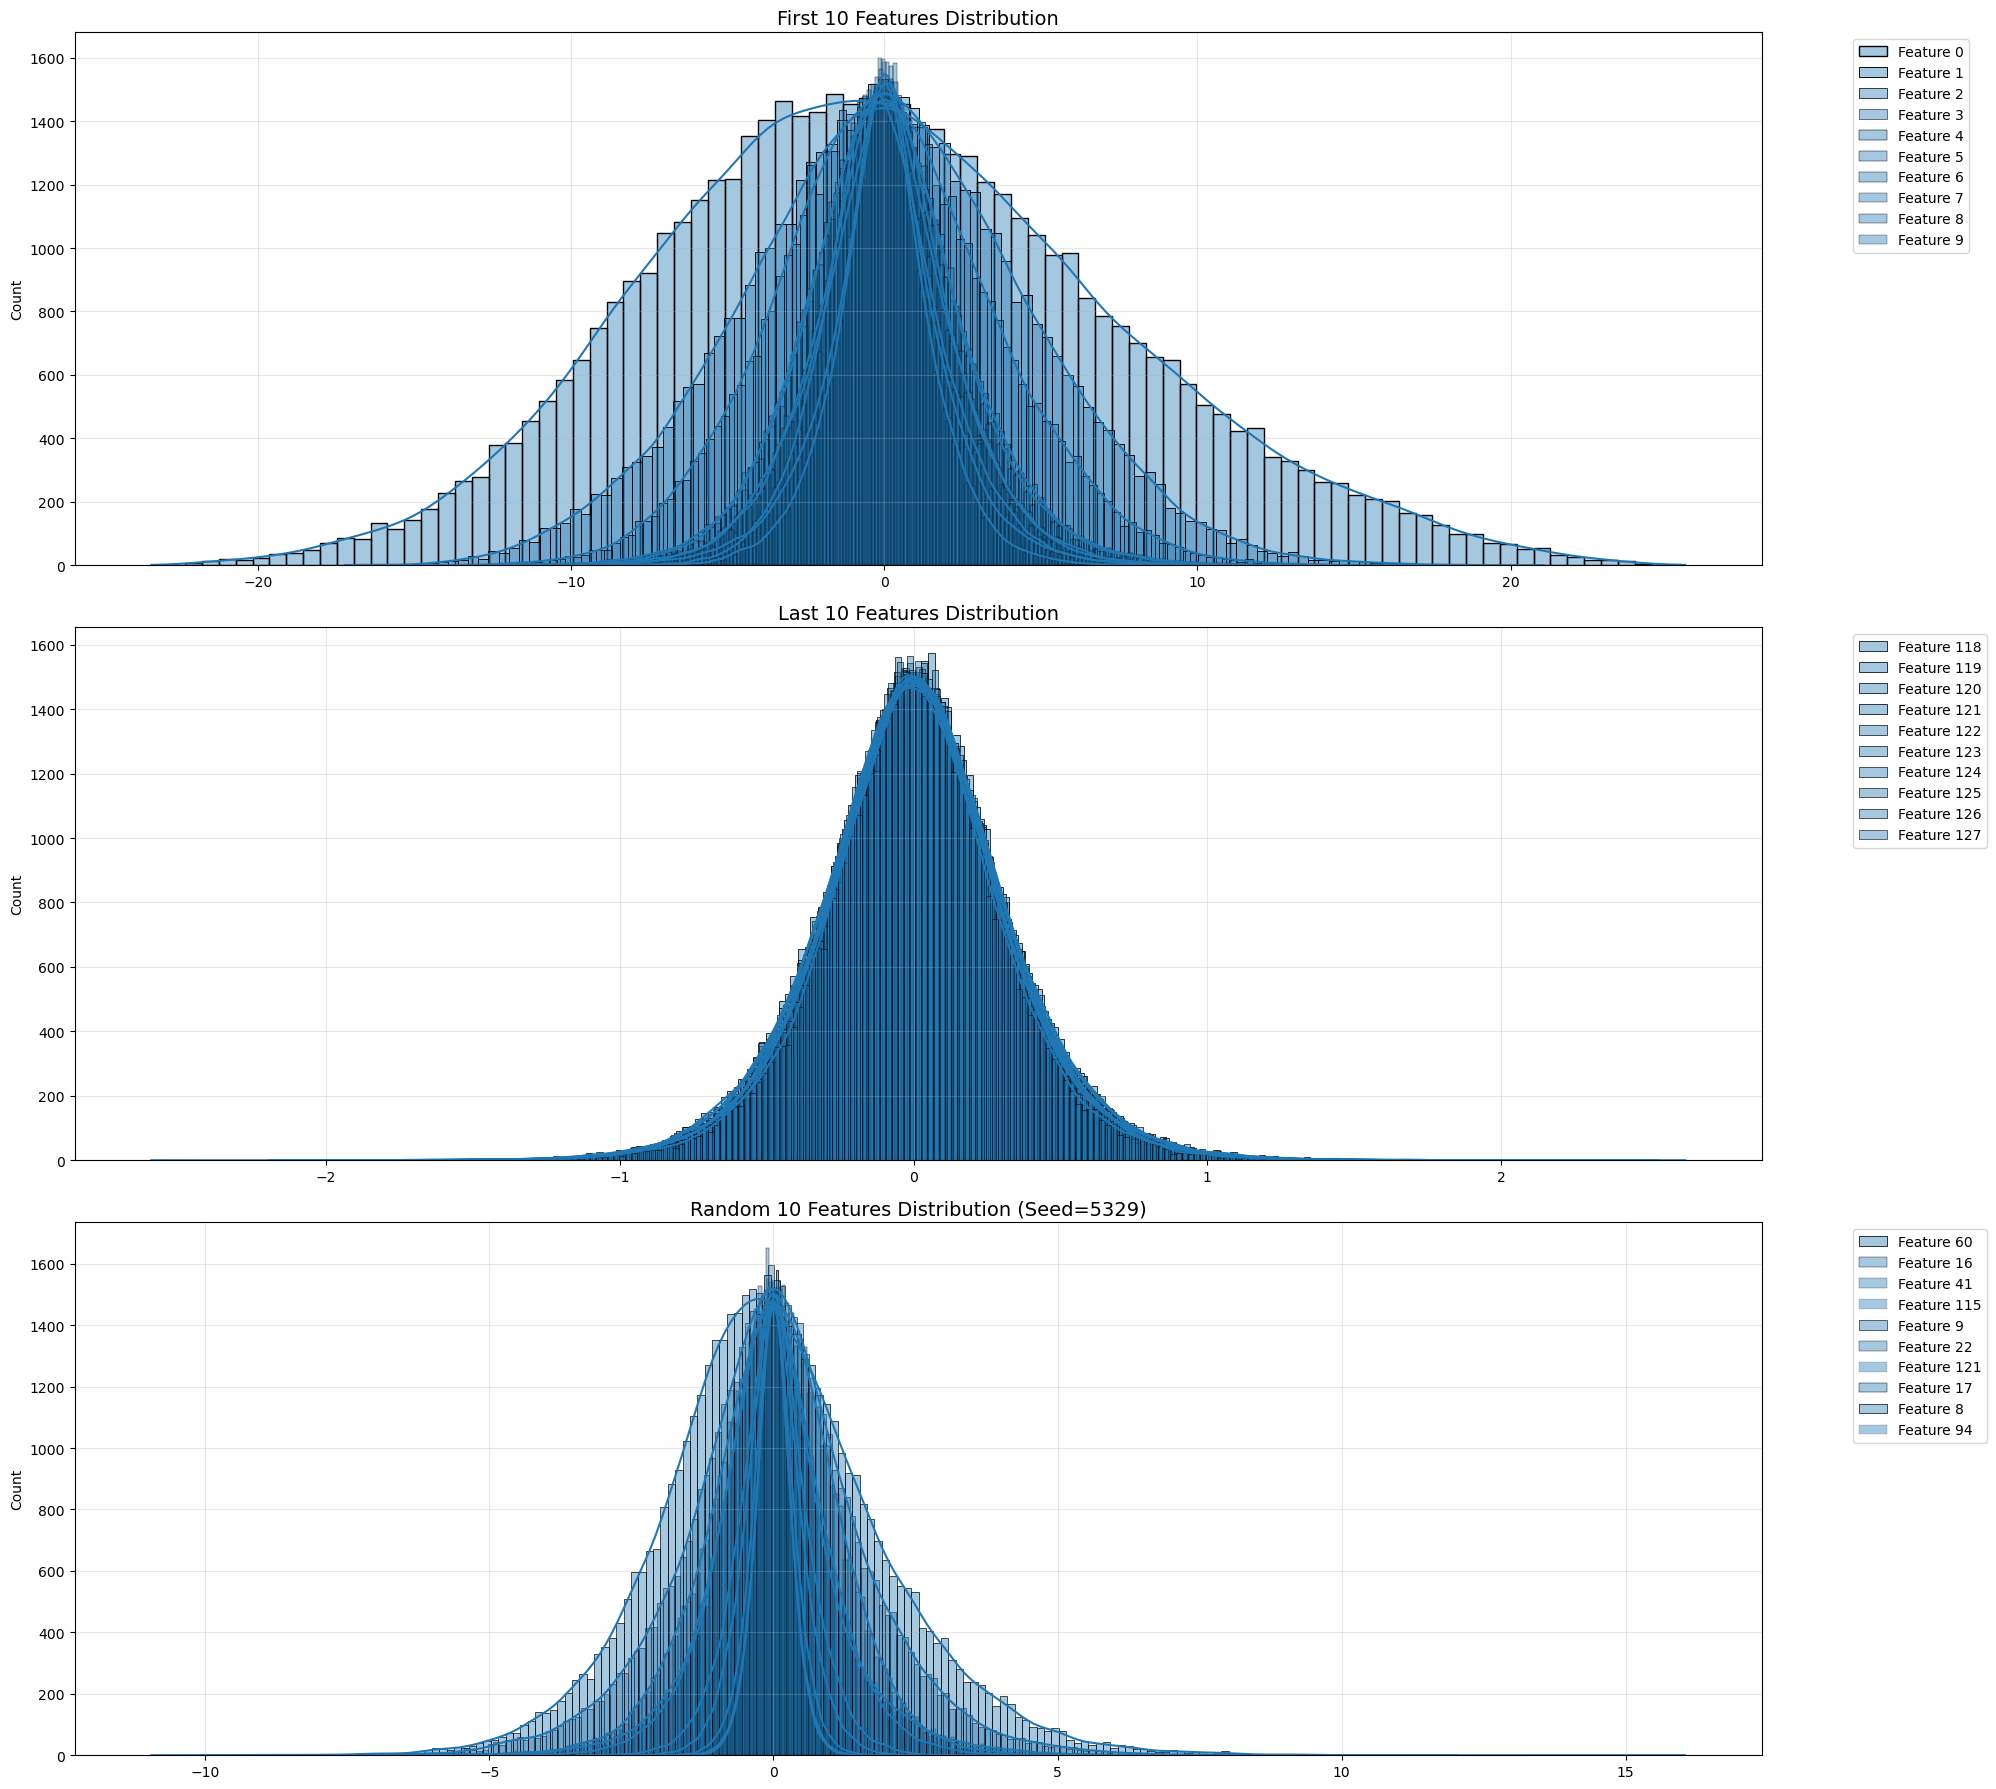

In [36]:
# Set random seed for reproducibility
np.random.seed(5329)

# Feature indices
num_features = train_data.shape[1]
first_10 = range(10)                   # First 10 features
last_10 = range(num_features-10, num_features)  # Last 10 features
random_10 = np.random.choice(num_features, 10, replace=False)  # Random 10 features

# Plot settings
plt.figure(figsize=(20, 18))

# --- First 10 Features ---
plt.subplot(3, 1, 1)
for i in first_10:
    sns.histplot(train_data[:, i], kde=True, alpha=0.4, label=f'Feature {i}')
plt.title('First 10 Features Distribution', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)

# --- Last 10 Features ---
plt.subplot(3, 1, 2)
for i in last_10:
    sns.histplot(train_data[:, i], kde=True, alpha=0.4, label=f'Feature {i}')
plt.title('Last 10 Features Distribution', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)

# --- Random 10 Features ---
plt.subplot(3, 1, 3)
for i in random_10:
    sns.histplot(train_data[:, i], kde=True, alpha=0.4, label=f'Feature {i}')
plt.title(f'Random 10 Features Distribution (Seed=5329)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
def pre_processing(X, mode=None):
    if mode == 'min-max':
        print('Pre-process: min-max normalization')
        min_each_feature = np.min(X, axis=0)
        max_each_feature = np.max(X, axis=0)
        scale = max_each_feature - min_each_feature
        scale[scale == 0] = 1   # To avoid divided by 0
        scaled_train = (X - min_each_feature) / scale
        return scaled_train

    if mode == 'standardization':
        print('Pre-process: standardization')
        std_each_feature = np.std(X, axis=0)
        mean_each_feature = np.mean(X, axis=0)
        std_each_feature[std_each_feature == 0] = 1     # To avoid divided by 0
        norm_train = (X - mean_each_feature) / std_each_feature
        norm_test = (X - mean_each_feature) / std_each_feature
        return norm_train

    print('No pre-process')

    return X

In [38]:
# Apply pre-processing to train_data
raw_data = train_data.copy()
minmax_data = pre_processing(raw_data, mode='min-max')
standardized_data = pre_processing(raw_data, mode='standardization')

# Reduce to 2D using PCA
pca = PCA(n_components=2)
raw_pca = pca.fit_transform(raw_data)
minmax_pca = pca.fit_transform(minmax_data)
standardized_pca = pca.fit_transform(standardized_data)

Pre-process: min-max normalization
Pre-process: standardization


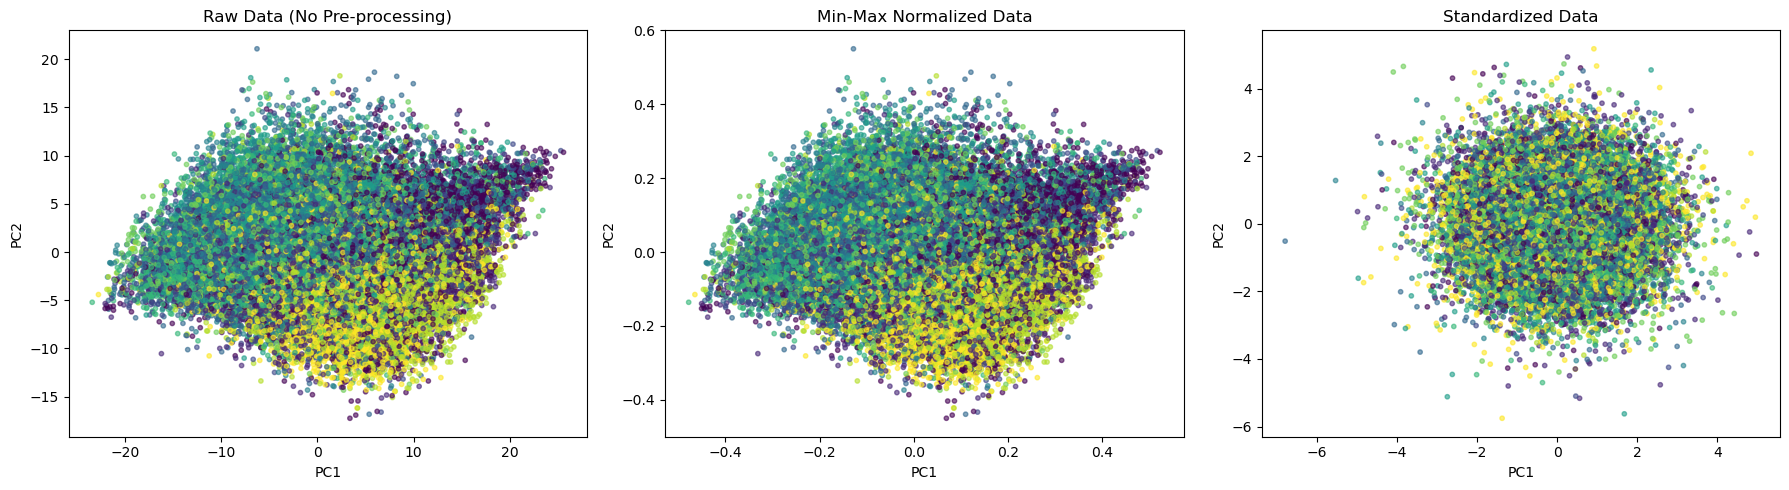

In [40]:
plt.figure(figsize=(18, 5))

# Raw Data
plt.subplot(1, 3, 1)
plt.scatter(raw_pca[:, 0], raw_pca[:, 1], c=train_label, cmap='viridis', alpha=0.6, s=10)
plt.title('Raw Data (No Pre-processing)')
plt.xlabel('PC1'); plt.ylabel('PC2')

# Min-Max Normalized
plt.subplot(1, 3, 2)
plt.scatter(minmax_pca[:, 0], minmax_pca[:, 1], c=train_label, cmap='viridis', alpha=0.6, s=10)
plt.title('Min-Max Normalized Data')
plt.xlabel('PC1'); plt.ylabel('PC2')

# Standardized
plt.subplot(1, 3, 3)
plt.scatter(standardized_pca[:, 0], standardized_pca[:, 1], c=train_label, cmap='viridis', alpha=0.6, s=10)
plt.title('Standardized Data')
plt.xlabel('PC1'); plt.ylabel('PC2')

plt.tight_layout()
plt.show()

Plot the distribution of the first 5 features before/after pre-processing:


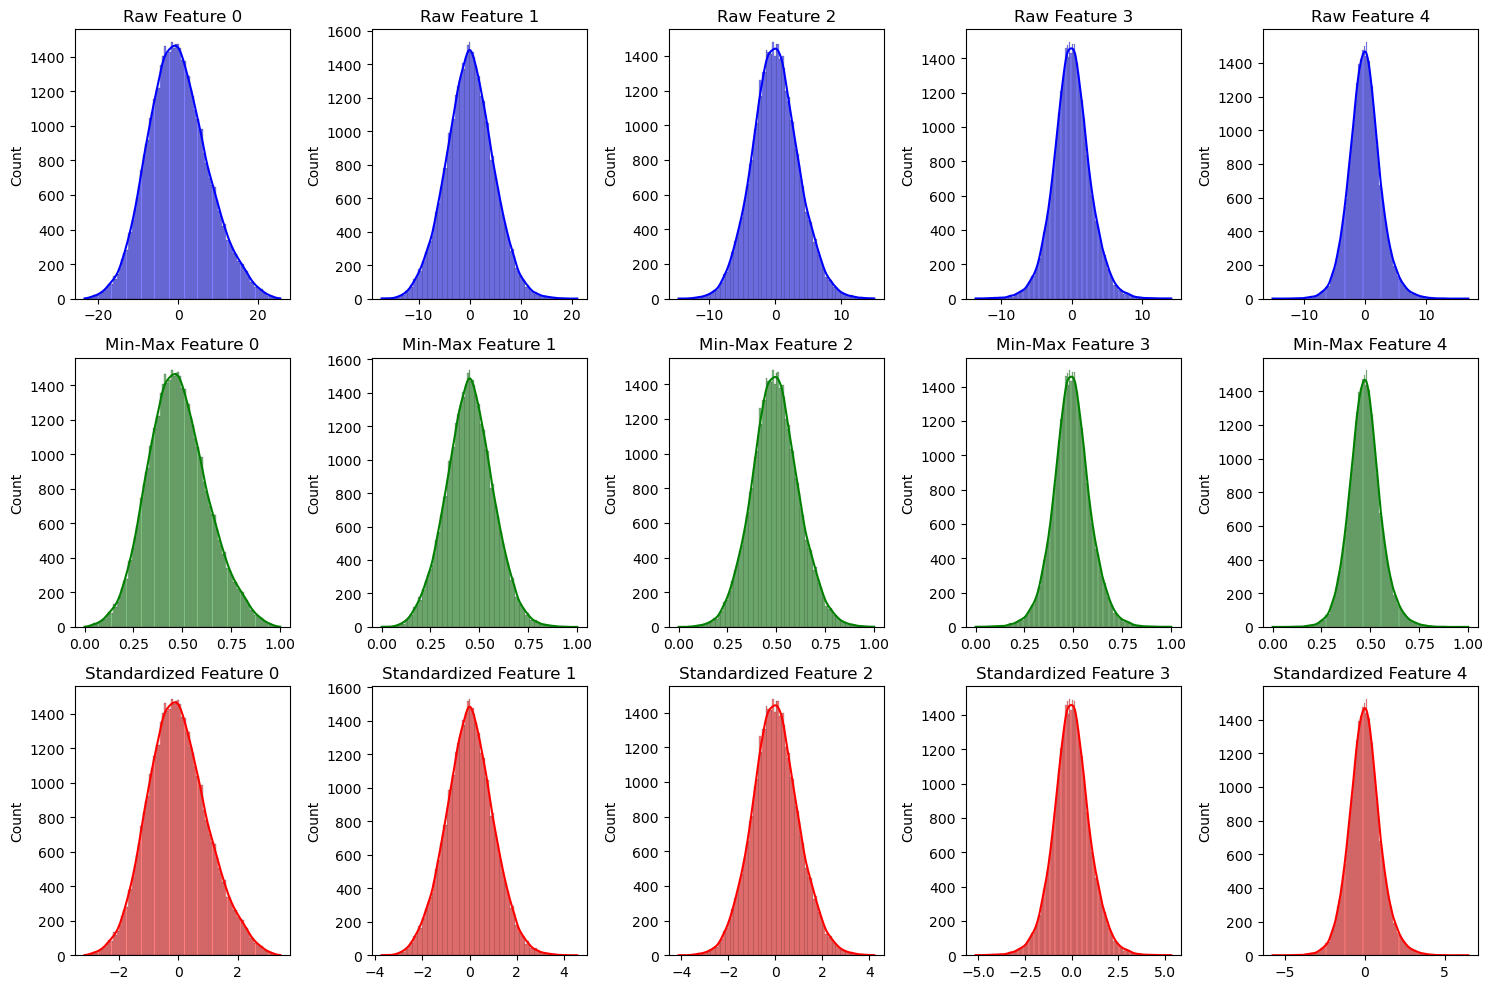

In [41]:
plt.figure(figsize=(15, 10))
for i in range(5):
    # Raw Data
    plt.subplot(3, 5, i+1)
    sns.histplot(raw_data[:, i], kde=True, color='blue')
    plt.title(f'Raw Feature {i}')
    
    # Min-Max
    plt.subplot(3, 5, i+6)
    sns.histplot(minmax_data[:, i], kde=True, color='green')
    plt.title(f'Min-Max Feature {i}')
    
    # Standardized
    plt.subplot(3, 5, i+11)
    sns.histplot(standardized_data[:, i], kde=True, color='red')
    plt.title(f'Standardized Feature {i}')

plt.tight_layout()
plt.show()


In [ ]:
train_X, val_X, train_y, val_y = train_test_split(train_data, train_label, test_size=0.2, random_state=5329, shuffle=True)